# 2. Neural Network for Classification

In [1]:
# import libraries

from sklearn.datasets import make_circles
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from torch import nn
import numpy as np
from torchsummary import summary
from sklearn.datasets import make_blobs

In [2]:
# create dataset using sklearn library
n_samples = 1000
# make target to be 2 classes  
X, y = make_circles(n_samples, 
                    noise=0.08,
                    random_state = 42)

In [5]:
circles = pd.DataFrame({'X1':X[:,0], 
                        'X2':X[:,1],
                        'y':y})

circles.head(5)

,X1,X2,y
0,0.724148,0.269493,1
1,-0.700842,0.191841,1
2,-0.851559,0.294974,1
3,-0.482243,0.641251,1
4,0.450694,-0.892254,0


Type of data <class 'numpy.ndarray'>
 Shap of features is (1000, 2)
 Shape of target is (1000,)


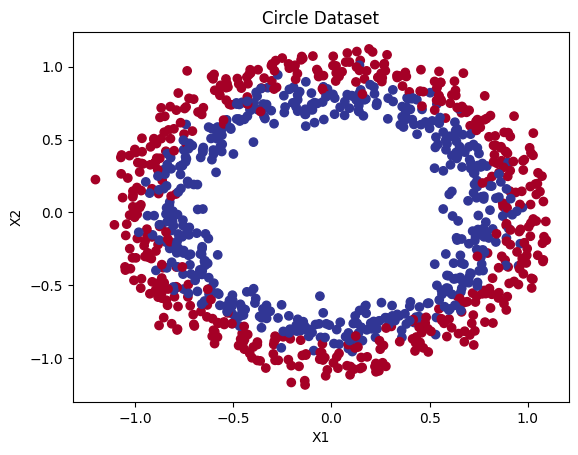

In [6]:
plt.scatter(X[:,0], X[:,1], c=y, cmap = plt.cm.RdYlBu)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Circle Dataset');

print(f"Type of data {type(X)}\n Shap of features is {X.shape}\n Shape of target is {y.shape}")

In [7]:
# since the type of data is numpy
# change type of data to tensor
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7241,  0.2695],
         [-0.7008,  0.1918],
         [-0.8516,  0.2950],
         [-0.4822,  0.6413],
         [ 0.4507, -0.8923]]),
 tensor([1., 1., 1., 1., 0.]))

In [8]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)


(800, 200, 800, 200)

In [9]:
device = 'cuda' if torch.cuda.is_available() else "cpu"
print(f'Device is {device}.')

Device is cpu.


In [10]:
# Create Linear Model with 2 layers
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)
    # in_feature of layer 2 must have the same number of out_feature in layer 1

  def forward(self, x):
    return self.layer_2(self.layer_1(x))

model_0 = CircleModelV0().to(device)

model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [11]:
# Replicate CircleModelV0 with nn.Sequential
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [12]:
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.3503],
        [-0.3854],
        [-0.1834],
        [-0.4108],
        [-0.0631],
        [-0.0918],
        [-0.3046],
        [-0.2433],
        [-0.1595],
        [-0.3937]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [13]:
# BCEWithLogitsLoss() dont have to use sigmoid in the last layer
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model_0.parameters(),
                            lr = 0.1)

In [14]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
  # torch.eq calculate where 2 tensors are equal
  correct = torch.eq(y_true, y_pred).sum().item()
  return correct / len(y_pred) * 100

In [16]:
y_logits = model_0(X_test.to(device))[:5]
print(f'logits of y_hat: {y_logits}')
# logits is just only beta.T*X
y_pred_probs = torch.sigmoid(y_logits)
print(f'prediction probability of y_hat {y_pred_probs}')

y_pred = torch.round(y_pred_probs)
print(f'Prediction of y_hat {y_pred.squeeze()}')

print(f'y_test {y_test[:5]}')

# And the use of the sigmoid activation function is not required 
# when passing our model's raw outputs to the nn.BCEWithLogitsLoss 
# (the "logits" in logits loss is because it works on the model's raw logits output), 
# this is because it has a sigmoid function built-in.

logits of y_hat: tensor([[-0.3503],
        [-0.3854],
        [-0.1834],
        [-0.4108],
        [-0.0631]], grad_fn=<SliceBackward0>)
prediction probability of y_hat tensor([[0.4133],
        [0.4048],
        [0.4543],
        [0.3987],
        [0.4842]], grad_fn=<SigmoidBackward0>)
Prediction of y_hat tensor([0., 0., 0., 0., 0.], grad_fn=<SqueezeBackward0>)
y_test tensor([1., 0., 1., 0., 1.])


In [17]:
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  ### training
  model_0.train() 

  # 1. Forward pass
  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  # 2. calculate loss
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)
  
  # 3. optimizer
  optimizer.zero_grad()

  # 4. loss
  loss.backward()

  # 5. step
  optimizer.step()

  # testing
  model_0.eval()
  with torch.inference_mode():
    # forward pass
    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    # calculate loss / acc
    test_loss = loss_fn(y_test, test_pred)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.70195, Accuracy: 50.00% | Test loss: 1.00320, Test acc: 50.00%
Epoch: 10 | Loss: 0.69697, Accuracy: 43.12% | Test loss: 0.98820, Test acc: 44.00%
Epoch: 20 | Loss: 0.69513, Accuracy: 45.62% | Test loss: 0.88320, Test acc: 50.50%
Epoch: 30 | Loss: 0.69434, Accuracy: 47.25% | Test loss: 0.84320, Test acc: 49.50%
Epoch: 40 | Loss: 0.69393, Accuracy: 47.62% | Test loss: 0.81820, Test acc: 50.00%
Epoch: 50 | Loss: 0.69368, Accuracy: 48.25% | Test loss: 0.79820, Test acc: 51.00%
Epoch: 60 | Loss: 0.69351, Accuracy: 48.88% | Test loss: 0.79320, Test acc: 51.00%
Epoch: 70 | Loss: 0.69339, Accuracy: 49.00% | Test loss: 0.79320, Test acc: 49.00%
Epoch: 80 | Loss: 0.69330, Accuracy: 51.00% | Test loss: 0.78320, Test acc: 49.50%
Epoch: 90 | Loss: 0.69323, Accuracy: 49.62% | Test loss: 0.78320, Test acc: 47.00%


In [18]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    # xx = X1, yy = X2

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

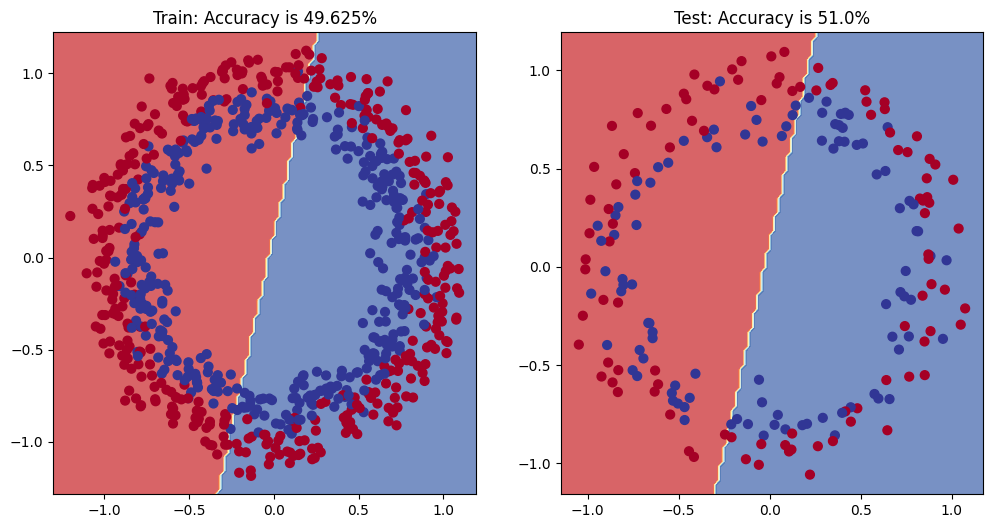

In [19]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title(f"Train: Accuracy is {acc}%")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title(f"Test: Accuracy is {test_acc}%")
plot_decision_boundary(model_0, X_test, y_test)

It should not use linear model since dataset cannot calssify by using linear classifier.

In [20]:
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()
    # self.sigmoid = nn.Sigmoid() it can be used in the last layer so we dont have to pass sigmoid anymore
    # using ReLU activation function because it is a non-linear activation function to make this model non-linear
  def forward(self, x):
    
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_2 = CircleModelV2().to(device)

print(model_2)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [21]:
print(summary(model_2, (1000,2)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 1000, 10]              30
              ReLU-2             [-1, 1000, 10]               0
            Linear-3             [-1, 1000, 10]             110
              ReLU-4             [-1, 1000, 10]               0
            Linear-5              [-1, 1000, 1]              11
Total params: 151
Trainable params: 151
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.31
Params size (MB): 0.00
Estimated Total Size (MB): 0.32
----------------------------------------------------------------
None


In [22]:
# Setup loss and optimizer 
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [23]:
torch.manual_seed(42)
epochs = 2000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

  y_logits = model_2(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                     y_pred = y_pred)
  
  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_2.eval()
  with torch.inference_mode():
    test_logits = model_2(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true=y_test,
                          y_pred=test_pred)
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69296, Accuracy: 50.12% | Test Loss: 0.69341, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.69124, Accuracy: 52.62% | Test Loss: 0.69160, Test Accuracy: 52.00%
Epoch: 200 | Loss: 0.68982, Accuracy: 53.37% | Test Loss: 0.69029, Test Accuracy: 54.50%
Epoch: 300 | Loss: 0.68788, Accuracy: 53.62% | Test Loss: 0.68846, Test Accuracy: 54.00%
Epoch: 400 | Loss: 0.68509, Accuracy: 54.00% | Test Loss: 0.68585, Test Accuracy: 54.50%
Epoch: 500 | Loss: 0.68118, Accuracy: 54.75% | Test Loss: 0.68227, Test Accuracy: 55.00%
Epoch: 600 | Loss: 0.67576, Accuracy: 55.12% | Test Loss: 0.67754, Test Accuracy: 56.50%
Epoch: 700 | Loss: 0.66796, Accuracy: 58.13% | Test Loss: 0.67095, Test Accuracy: 58.00%
Epoch: 800 | Loss: 0.65566, Accuracy: 63.25% | Test Loss: 0.66111, Test Accuracy: 65.00%
Epoch: 900 | Loss: 0.63428, Accuracy: 68.62% | Test Loss: 0.64418, Test Accuracy: 70.00%
Epoch: 1000 | Loss: 0.59563, Accuracy: 77.12% | Test Loss: 0.61662, Test Accuracy: 74.00%
Epoch: 1100 | Loss: 0.

In [24]:
model_2.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_2(X_test))).squeeze()

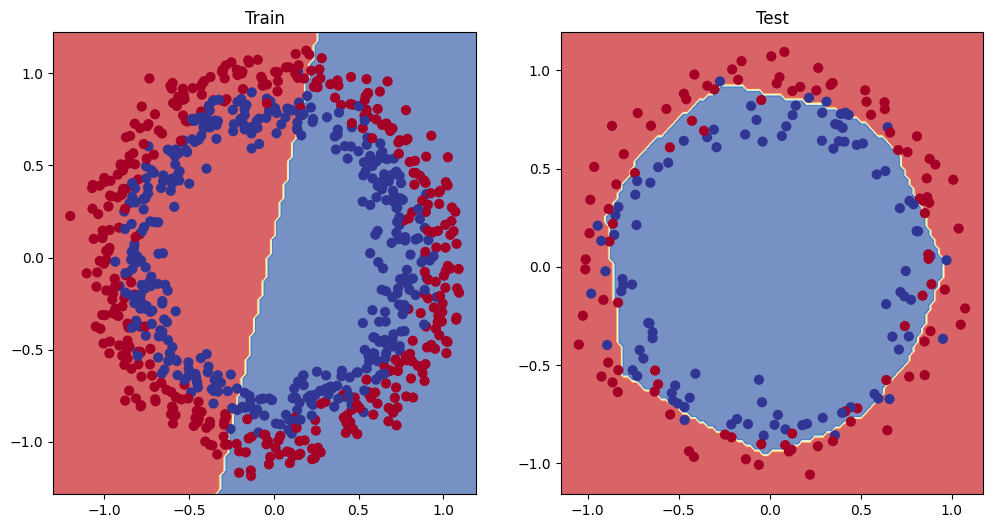

In [25]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test) # model_3 = has non-linearity

Multiclass Classification

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


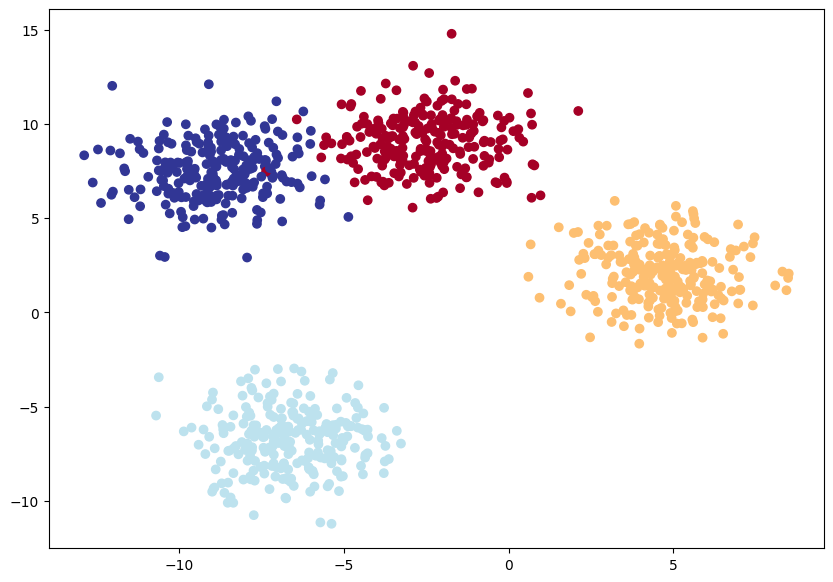

In [26]:
NUM_CLASSES = 4
NUM_FEATURES = 2 # easy to visualize
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [27]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [28]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):


    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
    )
  def forward(self, x):
    return self.linear_layer_stack(x)

model_3 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_3

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [29]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr = 0.1)

In [30]:
y_logits = model_3(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(f'logits of prediction {y_logits[:5]}')
print(f'prediction probabilities {y_pred_probs[:5]}')
print(f'Sum of probability {torch.sum(y_pred_probs[0,:])}')

print(y_pred_probs[0])
print(f'Index that has highest prob: {torch.argmax(y_pred_probs[0])}')

logits of prediction tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], grad_fn=<SliceBackward0>)
prediction probabilities tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]], grad_fn=<SliceBackward0>)
Sum of probability 1.0
tensor([0.1872, 0.2918, 0.1495, 0.3715], grad_fn=<SelectBackward0>)
Index that has highest prob: 3


In [31]:
torch.manual_seed(42)

epochs = 2000

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):

  model_3.train()

  y_logits = model_3(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_pred, y_blob_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    # 2. Calculate test loss and accuracy
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.04324, Acc: 65.50% | Test Loss: 0.57861, Test Acc: 95.50%
Epoch: 100 | Loss: 0.03185, Acc: 99.12% | Test Loss: 0.02293, Test Acc: 99.50%
Epoch: 200 | Loss: 0.02707, Acc: 99.12% | Test Loss: 0.01704, Test Acc: 99.50%
Epoch: 300 | Loss: 0.02564, Acc: 99.25% | Test Loss: 0.01499, Test Acc: 99.50%
Epoch: 400 | Loss: 0.02492, Acc: 99.25% | Test Loss: 0.01389, Test Acc: 99.50%
Epoch: 500 | Loss: 0.02444, Acc: 99.25% | Test Loss: 0.01318, Test Acc: 99.50%
Epoch: 600 | Loss: 0.02407, Acc: 99.25% | Test Loss: 0.01265, Test Acc: 99.50%
Epoch: 700 | Loss: 0.02377, Acc: 99.25% | Test Loss: 0.01224, Test Acc: 99.50%
Epoch: 800 | Loss: 0.02349, Acc: 99.25% | Test Loss: 0.01190, Test Acc: 99.50%
Epoch: 900 | Loss: 0.02325, Acc: 99.25% | Test Loss: 0.01160, Test Acc: 99.50%
Epoch: 1000 | Loss: 0.02302, Acc: 99.38% | Test Loss: 0.01134, Test Acc: 99.50%
Epoch: 1100 | Loss: 0.02281, Acc: 99.38% | Test Loss: 0.01110, Test Acc: 99.50%
Epoch: 1200 | Loss: 0.02261, Acc: 99.38% | Test Loss

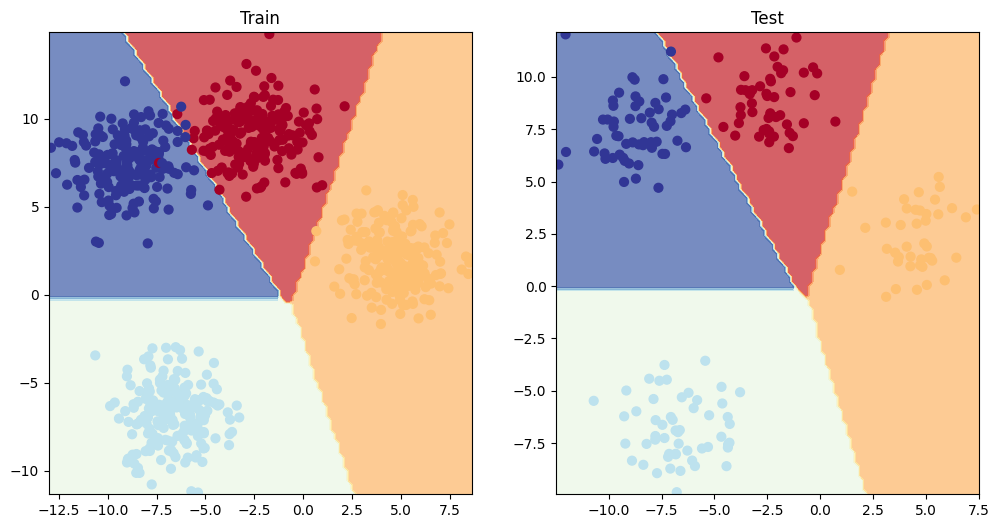

In [32]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_3, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_blob_test, y_blob_test)

As you can see this dataset has more than 2 class but it can be classified using linear classifier. Hence, linear model is sufficient for this dataset.

# Spiral Dataset

In [33]:
from sklearn.datasets import make_circles
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import train_test_split
from torch import nn
import numpy as np
from torchsummary import summary
from sklearn.datasets import make_blobs
import seaborn as sns

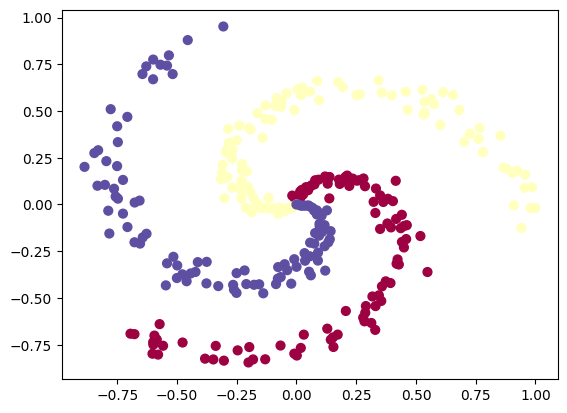

In [34]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()


In [35]:
X_train, X_test, y_train, y_test = train_test_split(torch.from_numpy(X).type(torch.float),
    torch.from_numpy(y),
    test_size=0.2,
    random_state=42
)

In [36]:
class ModelSpiral(nn.Module):
  def __init__(self, input_fea, output_fea, hidden=8):
    super().__init__()
    self.linear_1 = nn.Linear(in_features=input_fea, out_features=hidden)
    self.linear_2 = nn.Linear(in_features=hidden, out_features=hidden)
    self.linear_3 = nn.Linear(in_features=hidden, out_features=output_fea)
    self.Relu = nn.ReLU()

  def forward(self, x):
    return self.linear_3(self.Relu(self.linear_2(self.Relu(self.linear_1(x)))))
model_4 = ModelSpiral(input_fea = D,
                      output_fea = K,
                      hidden = 10).to(device)
model_4

ModelSpiral(
  (linear_1): Linear(in_features=2, out_features=10, bias=True)
  (linear_2): Linear(in_features=10, out_features=10, bias=True)
  (linear_3): Linear(in_features=10, out_features=3, bias=True)
  (Relu): ReLU()
)

In [37]:
summary(model_4, (N,D))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 100, 10]              30
              ReLU-2              [-1, 100, 10]               0
            Linear-3              [-1, 100, 10]             110
              ReLU-4              [-1, 100, 10]               0
            Linear-5               [-1, 100, 3]              33
Total params: 173
Trainable params: 173
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.00
Estimated Total Size (MB): 0.03
----------------------------------------------------------------


In [38]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_4.parameters(),
                             lr = 0.001)

In [39]:
X_train.shape

torch.Size([240, 2])

In [40]:
torch.manual_seed(42)

epochs = 3000
train_loss_hist = []
test_loss_hist = []
train_acc_hist = []
test_acc_hist = []
X_train, y_train = X_train.to(device), y_train.to(device) 
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):

  model_4.train()

  y_logits = model_4(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_train)
  train_loss_hist.append(loss.item())
  acc = accuracy_fn(y_train, y_pred)
  train_acc_hist.append(acc)
  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  #train_loss.append(loss.item())

  model_4.eval()
  with torch.inference_mode():
    test_logits = model_4(X_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_test)
    test_loss_hist.append(test_loss.item())
    test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)
    test_acc_hist.append(test_acc)
  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.11729, Acc: 32.50% | Test Loss: 1.11078, Test Acc: 36.67%
Epoch: 100 | Loss: 1.07522, Acc: 32.50% | Test Loss: 1.07561, Test Acc: 36.67%
Epoch: 200 | Loss: 1.00456, Acc: 54.58% | Test Loss: 1.00808, Test Acc: 48.33%
Epoch: 300 | Loss: 0.90143, Acc: 59.17% | Test Loss: 0.91722, Test Acc: 46.67%
Epoch: 400 | Loss: 0.81733, Acc: 60.83% | Test Loss: 0.85080, Test Acc: 48.33%
Epoch: 500 | Loss: 0.75985, Acc: 59.17% | Test Loss: 0.80555, Test Acc: 46.67%
Epoch: 600 | Loss: 0.66352, Acc: 64.17% | Test Loss: 0.72603, Test Acc: 51.67%
Epoch: 700 | Loss: 0.56464, Acc: 67.08% | Test Loss: 0.64211, Test Acc: 55.00%
Epoch: 800 | Loss: 0.50446, Acc: 72.08% | Test Loss: 0.58223, Test Acc: 63.33%
Epoch: 900 | Loss: 0.46272, Acc: 75.00% | Test Loss: 0.53279, Test Acc: 68.33%
Epoch: 1000 | Loss: 0.42662, Acc: 78.33% | Test Loss: 0.48334, Test Acc: 70.00%
Epoch: 1100 | Loss: 0.39298, Acc: 81.67% | Test Loss: 0.43654, Test Acc: 75.00%
Epoch: 1200 | Loss: 0.35867, Acc: 84.58% | Test Loss

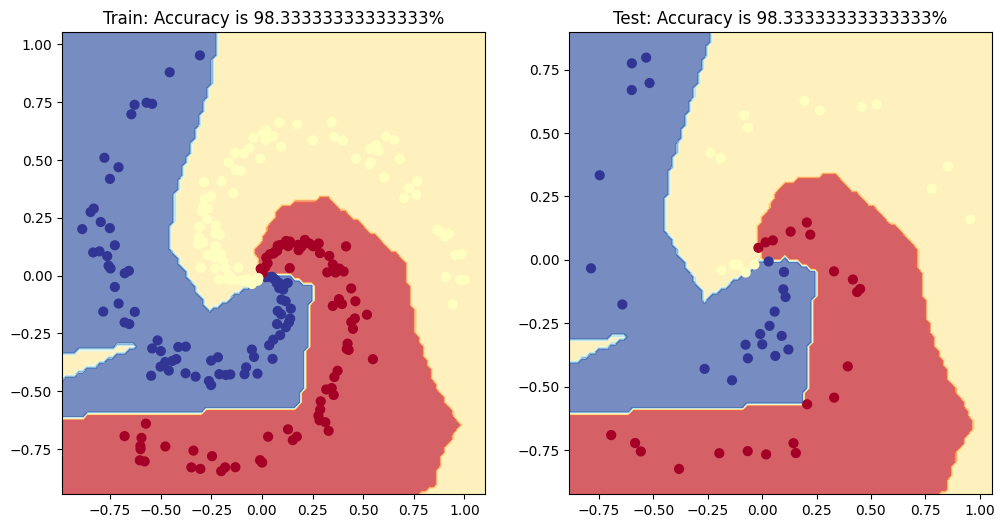

In [41]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title(f"Train: Accuracy is {acc}%")
plot_decision_boundary(model_4, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title(f"Test: Accuracy is {test_acc}%")
plot_decision_boundary(model_4, X_test, y_test)

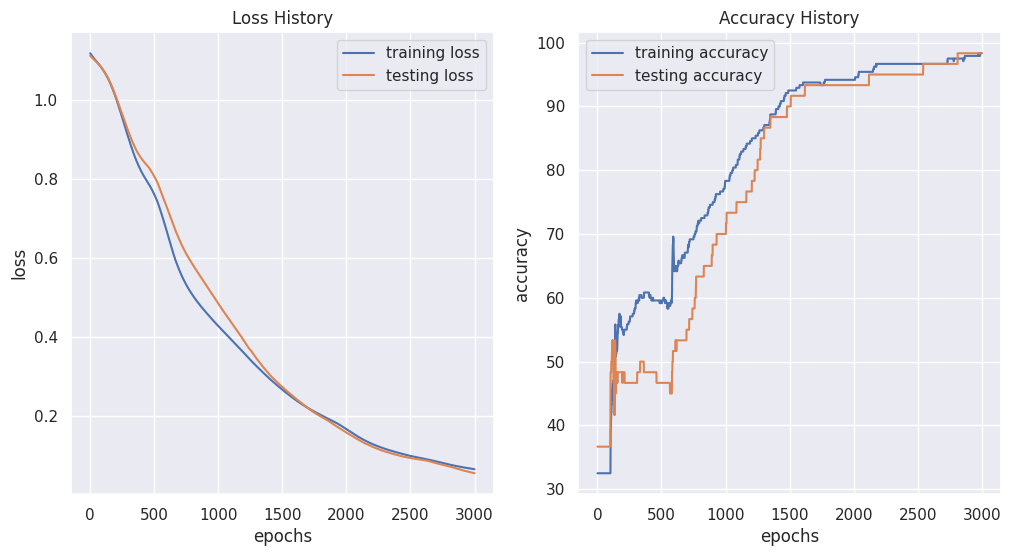

In [42]:
sns.set()
plt.figure(figsize=(12, 6))
ep = np.arange(1,3001)
plt.subplot(1, 2, 1)
plt.plot(ep, train_loss_hist, label='training loss')
plt.plot(ep, test_loss_hist, label = 'testing loss')
plt.title(f"Loss History")
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(ep, train_acc_hist, label='training accuracy')
plt.plot(ep, test_acc_hist, label='testing accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title(f"Accuracy History")
plt.legend()